In [17]:
import numpy as np

import lsst.daf.persistence as dafPersist
import lsst.afw.image.utils as afwImageUtils

%matplotlib inline
import matplotlib.pyplot as plt

butler = dafPersist.Butler(os.path.join(os.environ["SUPRIME_DATA_DIR"], 
                                        "rerun", "price/hsc-1236"))

In [18]:
visit = 1222 if False else 1246 if False else 1248
dataId=dict(visit=visit, ccd=44)

icCat = butler.get("icSrc", **dataId)
icMatchFull = butler.get("icMatchFull", **dataId)

cat = butler.get("src", **dataId)

In [19]:
import lsst.afw.display.ds9 as ds9

exp = butler.get("calexp", **dataId)

frame = 1
if False:
    ds9.mtv(exp, title="%(visit)d %(ccd)d" % dataId, frame=frame)

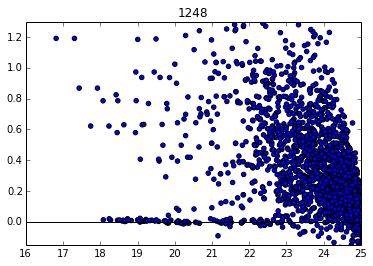

In [20]:
calib = exp.getCalib()
with afwImageUtils.CalibNoThrow():
    psfMag = calib.getMagnitude(cat.getPsfFlux())
    modelMag = calib.getMagnitude(cat.getModelFlux())
good = np.logical_not(cat.get("flags.pixel.saturated.center"))

plt.scatter(modelMag[good], psfMag[good] - modelMag[good])
plt.xlim(16, 25)
plt.ylim(-0.15, 1.3)
plt.title(str(visit))

_ = plt.axhline(0, color='black')

In [21]:
print icMatchFull.getSchema().extract("src.*model*flux*").keys()

['src.cmodel.exp.flux.apcorr', 'src.cmodel.flux', 'src.cmodel.flux.flags', 'src.cmodel.exp.flux.err', 'src.cmodel.exp.flux', 'src.apcorr.cmodel.flux.used', 'src.cmodel.dev.flux.apcorr', 'src.cmodel.initial.flux.err', 'src.cmodel.dev.flux.apcorr.err', 'src.cmodel.exp.flux.flags', 'src.apcorr.cmodel.dev.flux.used', 'src.apcorr.cmodel.exp.flux.used', 'src.cmodel.dev.flux.err', 'src.cmodel.flux.apcorr.err', 'src.cmodel.flux.apcorr', 'src.cmodel.exp.flux.flags.apcorr', 'src.cmodel.initial.flux.flags', 'src.cmodel.flux.err', 'src.cmodel.initial.flux', 'src.cmodel.exp.flux.apcorr.err', 'src.cmodel.dev.flux.flags.apcorr', 'src.cmodel.flux.flags.apcorr', 'src.cmodel.dev.flux.flags', 'src.cmodel.dev.flux']


In [22]:
filterName = exp.getFilter().getName()

calib = exp.getCalib()
with afwImageUtils.CalibNoThrow():
    psfMag = calib.getMagnitude(icMatchFull.get("src.flux.psf"))
    modelMag = calib.getMagnitude(icMatchFull.get("src.cmodel.flux"))

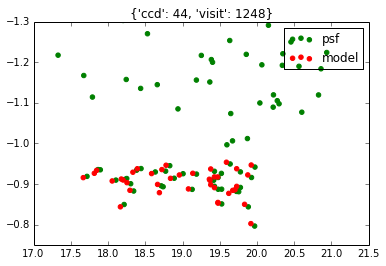

In [25]:
#
# Deal with colour terms
#
from lsst.meas.photocal.colorterms import ColortermLibraryConfig

colortermConfig = ColortermLibraryConfig()
colortermConfig.load(os.path.join(os.environ["OBS_SUBARU_DIR"], "config", "hsc", "colorterms.py"))
ct = colortermConfig.getColorTerm(filterName, "ps1_pv2")

refMags = []
for name in [ct.primary, ct.secondary]:
    refMags.append(-2.5*np.log10(icMatchFull.get("ref.%s" % name)))

refMag = ct.transformMags(*refMags)
    
if True:       # there shouldn't be any saturated stars in the calibration set
    good = np.ones_like(refMag, dtype=bool)
else:
    good = np.logical_not(icMatchFull.get("src.flags.pixel.saturated.center"))
    
plt.scatter(refMag[good]+0.05, refMag[good] - psfMag[good], color='green', label="psf")
plt.scatter(refMag[good], refMag[good] - modelMag[good], color='red', label="model")

plt.legend(loc='best')

#plt.xlim(16, 25)
plt.ylim(-2.5, 2.1)
plt.ylim(-0.75, -1.3)
plt.title(str(dataId))

_ = plt.axhline(0, color='black')